# Phase 3: Preprocessing & Feature Selection

**Objective**: Prepare data for modeling and select the best features for each task

**Input**: `engineered_features_dual_target.csv` (40 features + 2 targets)  
**Output**: Top 10 features for each task

**Steps**:
1. Load data 
2. Train/test split (temporal)
3. Feature selection for **Volatility Prediction** (Regression)
4. Feature selection for **Direction Prediction** (Classification)
5. Save final datasets & selected features

## 1. Setup & Data Loading

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor, XGBClassifier
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully")

Libraries loaded successfully


In [16]:
# Load engineered features
df = pd.read_csv('engineered_features_dual_target.csv')
df['open time'] = pd.to_datetime(df['open time'])

print(f"Loaded {len(df):,} rows")
print(f"Date range: {df['open time'].min()} to {df['open time'].max()}")
print(f"\nTotal columns: {len(df.columns)}")
print(f"Shape: {df.shape}")

Loaded 70,919 rows
Date range: 2018-01-01 00:00:00 to 2026-02-02 22:00:00

Total columns: 56
Shape: (70919, 56)


## 2. Handle NaN Values & Prepare Data

In [17]:
print("=== NaN COUNTS ===")
nan_counts = df.isna().sum()
features_with_nan = nan_counts[nan_counts > 0].sort_values(ascending=False)

if len(features_with_nan) > 0:
    print(f"\nFeatures with NaN values ({len(features_with_nan)} total):")
    for col, count in features_with_nan.items():
        pct = count / len(df) * 100
        print(f"  {col:30s}: {count:6,} ({pct:5.2f}%)")
else:
    print("No NaN values found!")

=== NaN COUNTS ===

Features with NaN values (31 total):
  volume_change_pct             :    126 ( 0.18%)
  taker_buy_ratio               :    125 ( 0.18%)
  volume_z_score                :     33 ( 0.05%)
  macd_histogram                :     33 ( 0.05%)
  trade_intensity               :     33 ( 0.05%)
  macd_signal                   :     33 ( 0.05%)
  macd                          :     25 ( 0.04%)
  close_vol_24h                 :     24 ( 0.03%)
  bb_width_pct                  :     19 ( 0.03%)
  stoch_d                       :     17 ( 0.02%)
  atr_lag_3h                    :     16 ( 0.02%)
  stoch_k                       :     15 ( 0.02%)
  atr_lag_1h                    :     14 ( 0.02%)
  atr_pct                       :     13 ( 0.02%)
  atr_14                        :     13 ( 0.02%)
  close_vol_12h                 :     12 ( 0.02%)
  log_return_12h                :     12 ( 0.02%)
  return_lag_6h                 :      7 ( 0.01%)
  log_return_6h                 :      6 ( 

In [18]:
# Drop first 24 rows (rolling window) + forward/backward fill remaining
print(f"\nOriginal shape: {df.shape}")

# Drop first 24 rows (NaN comes from rolling windows)
df = df.iloc[24:].reset_index(drop=True)
print(f"After dropping first 24 rows: {df.shape}")

# Forward fill first 
df = df.ffill()
print(f"After forward fill: {df.shape}")

# Check remaining NaN
remaining_after_ffill = df.isna().sum().sum()
print(f"NaN remaining after ffill: {remaining_after_ffill}")

# Backward fill 
if remaining_after_ffill > 0:
    df = df.bfill()

# Verify no NaN in targets
target_nans = df[['target_reg', 'target_class']].isna().sum()
print(f"\nNaN in targets:")
print(f"  target_reg: {target_nans['target_reg']}")
print(f"  target_class: {target_nans['target_class']}")

# Final check
remaining_nans = df.isna().sum().sum()
print(f"\nTotal NaN remaining: {remaining_nans}")
assert remaining_nans == 0, "NaN values still exist!"


Original shape: (70919, 56)
After dropping first 24 rows: (70895, 56)
After forward fill: (70895, 56)
NaN remaining after ffill: 19

NaN in targets:
  target_reg: 0
  target_class: 0

Total NaN remaining: 0


## 3. Identify Feature Columns

In [19]:
#seperate from base columns and targets
base_columns = ['open time', 'open', 'high', 'low', 'close', 'volume', 
                'close time', 'quote asset volume', 'number of trades',
                'taker buy base asset volume', 'taker buy quote asset volume',
                'gk_volatility', 'target_reg', 'target_class', 'is_interpolated', 'ignore']

feature_columns = [col for col in df.columns if col not in base_columns]

print(f"Total feature columns: {len(feature_columns)}")
print(f"\nFeatures:")
for i, feat in enumerate(feature_columns, 1):
    print(f"{i:2d}. {feat}")

Total feature columns: 40

Features:
 1. log_return_1h
 2. atr_14
 3. bb_width_pct
 4. close_vol_6h
 5. close_vol_12h
 6. close_vol_24h
 7. atr_pct
 8. taker_buy_ratio
 9. volume_z_score
10. trade_intensity
11. volume_change_pct
12. log_return_3h
13. log_return_6h
14. log_return_12h
15. return_acceleration
16. hl_range_pct
17. close_position
18. rsi_14
19. macd
20. macd_signal
21. macd_histogram
22. stoch_k
23. stoch_d
24. ema_crossover
25. gk_lag_1h
26. gk_lag_3h
27. gk_lag_6h
28. gk_avg_3h
29. gk_avg_6h
30. atr_lag_1h
31. atr_lag_3h
32. return_lag_1h
33. return_lag_3h
34. return_lag_6h
35. hour_sin
36. hour_cos
37. day_sin
38. day_cos
39. is_funding_hour
40. is_weekend


## 4. Train/Test Split (Temporal)

- temporal split (not random)

In [20]:
# first 85% for training, last 15% for testing
split_index = int(len(df) * 0.85)

train = df.iloc[:split_index].copy()
test = df.iloc[split_index:].copy()

print(f"{'='*60}")
print(f"TRAIN/TEST SPLIT")
print(f"{'='*60}")
print(f"\nTrain set:")
print(f"  Rows: {len(train):,}")
print(f"  Date range: {train['open time'].min()} to {train['open time'].max()}")

print(f"\nTest set:")
print(f"  Rows: {len(test):,}")
print(f"  Date range: {test['open time'].min()} to {test['open time'].max()}")

TRAIN/TEST SPLIT

Train set:
  Rows: 60,260
  Date range: 2018-01-02 00:00:00 to 2024-11-16 19:00:00

Test set:
  Rows: 10,635
  Date range: 2024-11-16 20:00:00 to 2026-02-02 22:00:00


## 5. Feature Selection - REGRESSION (Volatility Prediction)

- Select Top 10 features for predicting `target_reg` (next-hour GK volatility)

**3-Tier Approach**:
1. Correlation → Top 30
2. Lasso → Top 20
3. RFE + XGBoost → Top 10

In [21]:
print(f"{'='*70}")
print(f"REGRESSION FEATURE SELECTION (target_reg)")
print(f"{'='*70}")

# Tier 1: Correlation filtering
X_train = train[feature_columns]
y_train_reg = train['target_reg']

correlations_reg = X_train.corrwith(y_train_reg, method='pearson').abs().sort_values(ascending=False)

print(f"\n--- Correlation Filtering ---")
print(f"\nTop 30 features by correlation with target_reg:")
print(correlations_reg.head(30))

top_30_reg = correlations_reg.head(30).index.tolist()
print(f"\nSelected: {len(top_30_reg)} features")

REGRESSION FEATURE SELECTION (target_reg)

--- Correlation Filtering ---

Top 30 features by correlation with target_reg:
gk_avg_3h            0.663261
gk_avg_6h            0.659247
hl_range_pct         0.652159
gk_lag_1h            0.549945
gk_lag_3h            0.493697
gk_lag_6h            0.452913
atr_14               0.263304
atr_lag_1h           0.251673
atr_lag_3h           0.240889
trade_intensity      0.202464
volume_z_score       0.192766
atr_pct              0.170549
close_vol_6h         0.159286
close_vol_12h        0.157157
close_vol_24h        0.154779
bb_width_pct         0.125585
macd                 0.119316
log_return_12h       0.115164
is_weekend           0.113037
macd_signal          0.108962
volume_change_pct    0.108073
day_sin              0.096205
log_return_6h        0.092355
rsi_14               0.083943
hour_sin             0.077304
log_return_3h        0.070340
ema_crossover        0.065219
hour_cos             0.061149
macd_histogram       0.054853
stoch_k 

In [22]:
# Tier 2: Lasso Regression (L1 regularization)
print(f"\n--- Lasso Regression ---")

# Standardize features for Lasso
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(train[top_30_reg])

# Lasso with cross-validation to find best alpha
lasso_reg = LassoCV(cv=5, random_state=42, max_iter=10000, n_jobs=-1)
lasso_reg.fit(X_train_reg_scaled, y_train_reg)

print(f"\nBest alpha: {lasso_reg.alpha_:.6f}")

# Extract non-zero coefficients
lasso_coefs_reg = pd.Series(lasso_reg.coef_, index=top_30_reg)
selected_reg_20 = lasso_coefs_reg[lasso_coefs_reg != 0].abs().sort_values(ascending=False)

print(f"\nLasso selected {len(selected_reg_20)} features:")
for feat, coef in selected_reg_20.items():
    print(f"  {feat:30s}: {coef:+.6f}")

selected_reg_20_list = selected_reg_20.index.tolist()


--- Lasso Regression ---

Best alpha: 0.000082

Lasso selected 12 features:
  hl_range_pct                  : +0.002058
  gk_avg_6h                     : +0.001676
  gk_lag_6h                     : +0.000319
  hour_cos                      : +0.000289
  gk_avg_3h                     : +0.000184
  gk_lag_1h                     : +0.000154
  trade_intensity               : +0.000121
  log_return_3h                 : +0.000103
  log_return_6h                 : +0.000039
  atr_lag_3h                    : +0.000037
  day_sin                       : +0.000010
  is_weekend                    : +0.000007


In [23]:
# Tier 3: RFE with XGBoost (Final Top 10)
print(f"\n--- Recursive Feature Elimination (RFE) with XGBoost ---")

# XGBoost regressor
estimator_reg = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

# RFE to select top 10
selector_reg = RFE(estimator_reg, n_features_to_select=10, step=2)

X_train_reg_scaled_df = pd.DataFrame(X_train_reg_scaled, columns=top_30_reg, index=train.index)
X_train_reg_selected = X_train_reg_scaled_df[selected_reg_20_list].values
selector_reg.fit(X_train_reg_selected, y_train_reg)

# Extract selected features
top_10_reg = [selected_reg_20_list[i] for i in range(len(selected_reg_20_list)) if selector_reg.support_[i]]

print(f"\n{'='*70}")
print(f"TOP 10 FEATURES FOR REGRESSION (Volatility Prediction)")
print(f"{'='*70}")
for i, feat in enumerate(top_10_reg, 1):
    print(f"{i:2d}. {feat}")


--- Recursive Feature Elimination (RFE) with XGBoost ---

TOP 10 FEATURES FOR REGRESSION (Volatility Prediction)
 1. hl_range_pct
 2. gk_avg_6h
 3. gk_lag_6h
 4. hour_cos
 5. gk_avg_3h
 6. gk_lag_1h
 7. trade_intensity
 8. log_return_3h
 9. log_return_6h
10. atr_lag_3h

TOP 10 FEATURES FOR REGRESSION (Volatility Prediction)
 1. hl_range_pct
 2. gk_avg_6h
 3. gk_lag_6h
 4. hour_cos
 5. gk_avg_3h
 6. gk_lag_1h
 7. trade_intensity
 8. log_return_3h
 9. log_return_6h
10. atr_lag_3h


## 6. Feature Selection - CLASSIFICATION 

- Select Top 10 features for predicting `target_class` (next-hour candle direction)

**3-Tier Approach**:
1. Correlation → Top 30
2. Logistic Lasso → Top 20
3. RFE + XGBoost → Top 10

In [24]:
print(f"\n{'='*70}")
print(f"CLASSIFICATION FEATURE SELECTION (target_class)")
print(f"{'='*70}")

# Tier 1: Correlation filtering
y_train_class = train['target_class']

correlations_class = X_train.corrwith(y_train_class).abs().sort_values(ascending=False)

print(f"\n--- Correlation Filtering ---")
print(f"\nTop 30 features by correlation with target_class:")
print(correlations_class.head(30))

top_30_class = correlations_class.head(30).index.tolist()
print(f"\nSelected: {len(top_30_class)} features")


CLASSIFICATION FEATURE SELECTION (target_class)

--- Correlation Filtering ---

Top 30 features by correlation with target_class:
close_position         0.101247
stoch_k                0.052675
taker_buy_ratio        0.052447
rsi_14                 0.052332
log_return_3h          0.041002
log_return_6h          0.040048
log_return_1h          0.032778
stoch_d                0.031738
log_return_12h         0.030691
macd_histogram         0.025866
ema_crossover          0.025397
return_lag_1h          0.015900
macd                   0.014653
hour_sin               0.012995
return_acceleration    0.010036
hl_range_pct           0.009914
gk_avg_3h              0.009537
gk_lag_1h              0.006754
macd_signal            0.006701
volume_change_pct      0.005818
gk_avg_6h              0.005758
is_funding_hour        0.004354
gk_lag_6h              0.003824
bb_width_pct           0.003523
atr_lag_3h             0.003418
volume_z_score         0.003371
close_vol_24h          0.003126
retur

In [26]:
# Tier 2: Logistic Regression with L1 (Lasso)
print(f"\n--- Logistic Lasso ---")

# Standardize features for Lasso
scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(train[top_30_class])

# Logistic Lasso with cross-validation
lasso_class = LogisticRegressionCV(
    cv=5,
    penalty='l1',
    solver='liblinear',
    random_state=42,
    max_iter=10000,
    n_jobs=-1
)
lasso_class.fit(X_train_class_scaled, y_train_class)

print(f"\nBest C (inverse regularization): {lasso_class.C_[0]:.6f}")

# Extract non-zero coefficients
lasso_coefs_class = pd.Series(lasso_class.coef_[0], index=top_30_class)
non_zero_class = lasso_coefs_class[lasso_coefs_class != 0].abs().sort_values(ascending=False)

# Take top 20 (in case Lasso keeps all 30)
selected_class_20 = non_zero_class.head(20)

print(f"\nLasso selected {len(non_zero_class)} non-zero features, taking top 20:")
for feat, coef in selected_class_20.items():
    print(f"  {feat:30s}: {coef:+.6f}")

selected_class_20_list = selected_class_20.index.tolist()


--- Logistic Lasso ---

Best C (inverse regularization): 0.359381

Lasso selected 27 non-zero features, taking top 20:
  stoch_k                       : +0.374155
  stoch_d                       : +0.253103
  close_position                : +0.172916
  return_lag_1h                 : +0.117014
  log_return_1h                 : +0.110072
  gk_avg_3h                     : +0.062411
  log_return_3h                 : +0.054865
  rsi_14                        : +0.054413
  log_return_12h                : +0.050193
  gk_avg_6h                     : +0.034744
  ema_crossover                 : +0.032061
  taker_buy_ratio               : +0.030626
  hour_sin                      : +0.030586
  gk_lag_1h                     : +0.027572
  volume_change_pct             : +0.023802
  macd_signal                   : +0.017215
  hl_range_pct                  : +0.013879
  trade_intensity               : +0.013826
  atr_lag_3h                    : +0.012013
  log_return_6h                 : +0.011296


In [27]:
# Tier 3: RFE with XGBoost Classifier (Final Top 10)
print(f"\n--- Recursive Feature Elimination (RFE) with XGBoost ---")

# XGBoost classifier
estimator_class = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

# RFE to select top 10
selector_class = RFE(estimator_class, n_features_to_select=10, step=2)
# X_train_class_selected = scaler_class.transform(train[selected_class_20_list])
X_train_class_scaled_df = pd.DataFrame(X_train_class_scaled, columns=top_30_class, index=train.index)
X_train_class_selected = X_train_class_scaled_df[selected_class_20_list].values

selector_class.fit(X_train_class_selected, y_train_class)

# Extract selected features
top_10_class = [selected_class_20_list[i] for i in range(len(selected_class_20_list)) if selector_class.support_[i]]

print(f"\n{'='*70}")
print(f"TOP 10 FEATURES FOR CLASSIFICATION")
print(f"{'='*70}")
for i, feat in enumerate(top_10_class, 1):
    print(f"{i:2d}. {feat}")


--- Recursive Feature Elimination (RFE) with XGBoost ---

TOP 10 FEATURES FOR CLASSIFICATION
 1. close_position
 2. return_lag_1h
 3. log_return_1h
 4. gk_avg_3h
 5. log_return_3h
 6. gk_lag_1h
 7. hl_range_pct
 8. trade_intensity
 9. atr_lag_3h
10. log_return_6h

TOP 10 FEATURES FOR CLASSIFICATION
 1. close_position
 2. return_lag_1h
 3. log_return_1h
 4. gk_avg_3h
 5. log_return_3h
 6. gk_lag_1h
 7. hl_range_pct
 8. trade_intensity
 9. atr_lag_3h
10. log_return_6h


## 7. Feature Overlap Analysis

In [28]:
# Compare selected features between tasks
overlap = set(top_10_reg).intersection(set(top_10_class))
unique_reg = set(top_10_reg) - set(top_10_class)
unique_class = set(top_10_class) - set(top_10_reg)

print(f"\n{'='*70}")
print(f"FEATURE OVERLAP ANALYSIS")
print(f"{'='*70}")

print(f"\nShared features (used by both tasks): {len(overlap)}")
if len(overlap) > 0:
    for feat in sorted(overlap):
        print(f"  - {feat}")
else:
    print("  None")

print(f"\nRegression-only features: {len(unique_reg)}")
if len(unique_reg) > 0:
    for feat in sorted(unique_reg):
        print(f"  - {feat}")

print(f"\nClassification-only features: {len(unique_class)}")
if len(unique_class) > 0:
    for feat in sorted(unique_class):
        print(f"  - {feat}")


FEATURE OVERLAP ANALYSIS

Shared features (used by both tasks): 7
  - atr_lag_3h
  - gk_avg_3h
  - gk_lag_1h
  - hl_range_pct
  - log_return_3h
  - log_return_6h
  - trade_intensity

Regression-only features: 3
  - gk_avg_6h
  - gk_lag_6h
  - hour_cos

Classification-only features: 3
  - close_position
  - log_return_1h
  - return_lag_1h


## 8. Feature Importance Visualization

In [29]:
# Reuse models from RFE for feature importance visualization

# Regression 
final_model_reg = estimator_reg
final_scaler_reg = scaler_reg

# Classification 
final_model_class = estimator_class
final_scaler_class = scaler_class

print("Models ready for visualization!")

Models ready for visualization!



Feature importance plot saved: feature_importances_top10.png


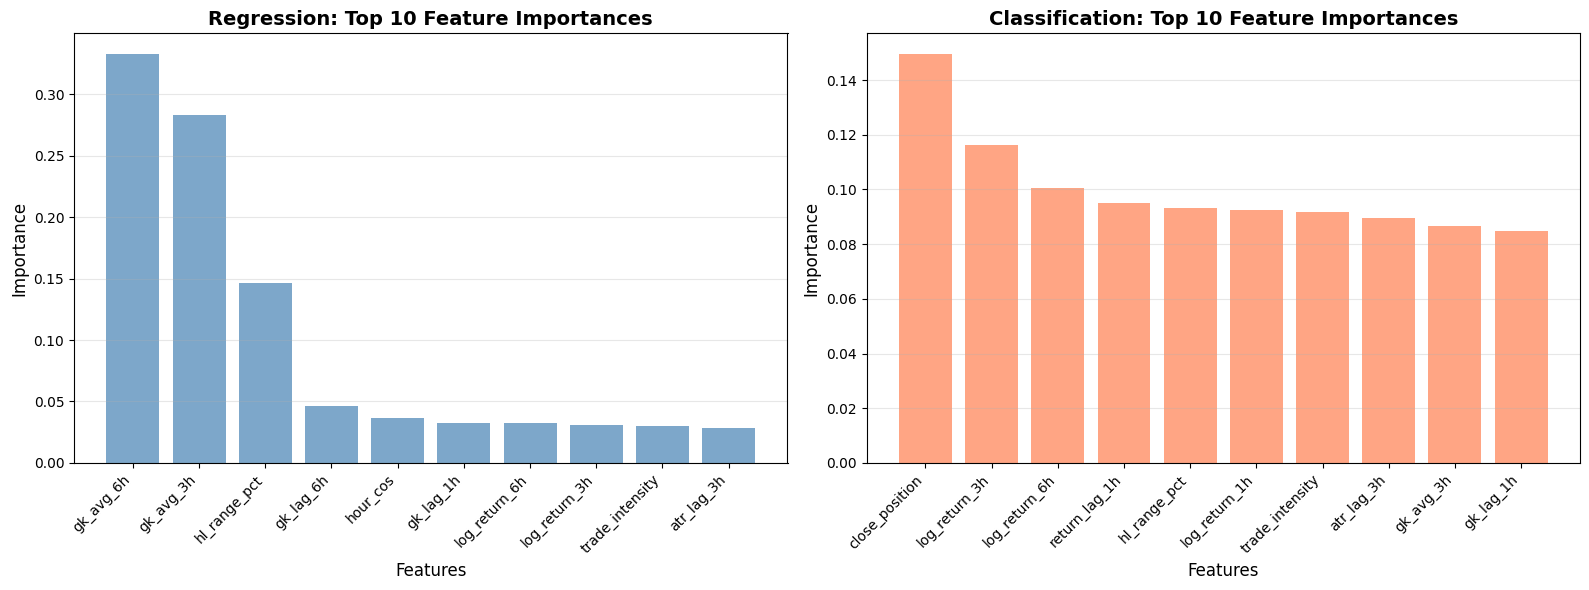

In [36]:
# Visualize feature importances
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Regression importances
# Fit scalers and final models on the selected top-10 features so feature_importances_ exist
final_scaler_reg = StandardScaler().fit(train[top_10_reg])
X_reg_scaled = final_scaler_reg.transform(train[top_10_reg])
final_model_reg.fit(X_reg_scaled, y_train_reg)
importances_reg = final_model_reg.feature_importances_

# Ensure the classification model is also fitted before its importances are accessed later
final_scaler_class = StandardScaler().fit(train[top_10_class])
X_class_scaled = final_scaler_class.transform(train[top_10_class])
final_model_class.fit(X_class_scaled, y_train_class)
indices_reg = np.argsort(importances_reg)[::-1]

axes[0].bar(range(10), importances_reg[indices_reg], color='steelblue', alpha=0.7)
axes[0].set_xticks(range(10))
axes[0].set_xticklabels([top_10_reg[i] for i in indices_reg], rotation=45, ha='right', fontsize=10)
axes[0].set_xlabel('Features', fontsize=12)
axes[0].set_ylabel('Importance', fontsize=12)
axes[0].set_title('Regression: Top 10 Feature Importances', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Classification importances
importances_class = final_model_class.feature_importances_
indices_class = np.argsort(importances_class)[::-1]

axes[1].bar(range(10), importances_class[indices_class], color='coral', alpha=0.7)
axes[1].set_xticks(range(10))
axes[1].set_xticklabels([top_10_class[i] for i in indices_class], rotation=45, ha='right', fontsize=10)
axes[1].set_xlabel('Features', fontsize=12)
axes[1].set_ylabel('Importance', fontsize=12)
axes[1].set_title('Classification: Top 10 Feature Importances', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importances_top10.png', dpi=150, bbox_inches='tight')
print("\nFeature importance plot saved: feature_importances_top10.png")
plt.show()

## 9. Save Final Datasets & Artifacts

In [ ]:
print(f"\n{'='*70}")
print(f"SAVING FINAL OUTPUTS")
print(f"{'='*70}")

# Create directories if they don't exist
import os
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Selected features (JSON)
with open('selected_features_regression.json', 'w') as f:
    json.dump(top_10_reg, f, indent=2)
print("\n✓ Saved: selected_features_regression.json")

with open('selected_features_classification.json', 'w') as f:
    json.dump(top_10_class, f, indent=2)
print("✓ Saved: selected_features_classification.json")

# Save scalers 
with open('models/scaler_regression.pkl', 'wb') as f:
    pickle.dump(final_scaler_reg, f)
print("✓ Saved: models/scaler_regression.pkl")

with open('models/scaler_classification.pkl', 'wb') as f:
    pickle.dump(final_scaler_class, f)
print("✓ Saved: models/scaler_classification.pkl")

# Save final training datasets
# Regression dataset
df_reg_train = train[['open time'] + top_10_reg + ['target_reg']].copy()
df_reg_test = test[['open time'] + top_10_reg + ['target_reg']].copy()

df_reg_train.to_csv('data/final_training_data_regression_train.csv', index=False)
df_reg_test.to_csv('data/final_training_data_regression_test.csv', index=False)
print("✓ Saved: data/final_training_data_regression_train.csv")
print("✓ Saved: data/final_training_data_regression_test.csv")

# Classification dataset
df_class_train = train[['open time'] + top_10_class + ['target_class']].copy()
df_class_test = test[['open time'] + top_10_class + ['target_class']].copy()

df_class_train.to_csv('data/final_training_data_classification_train.csv', index=False)
df_class_test.to_csv('data/final_training_data_classification_test.csv', index=False)
print("✓ Saved: data/final_training_data_classification_train.csv")
print("✓ Saved: data/final_training_data_classification_test.csv")


SAVING FINAL OUTPUTS

✓ Saved: selected_features_regression.json
✓ Saved: selected_features_classification.json
✓ Saved: models/scaler_regression.pkl
✓ Saved: models/scaler_classification.pkl
✓ Saved: data/final_training_data_regression_train.csv
✓ Saved: data/final_training_data_regression_test.csv
✓ Saved: data/final_training_data_regression_train.csv
✓ Saved: data/final_training_data_regression_test.csv
✓ Saved: data/final_training_data_classification_train.csv
✓ Saved: data/final_training_data_classification_test.csv
✓ Saved: data/final_training_data_classification_train.csv
✓ Saved: data/final_training_data_classification_test.csv


In [38]:
# Summary
print(f"\n{'='*70}")
print(f"PHASE 3 COMPLETE - PREPROCESSING & FEATURE SELECTION")
print(f"{'='*70}")

print(f"\nRegression (Volatility Prediction):")
print(f"  Selected Features: {len(top_10_reg)}")
print(f"  Train samples: {len(df_reg_train):,}")
print(f"  Test samples: {len(df_reg_test):,}")

print(f"\nClassification (Direction Prediction):")
print(f"  Selected Features: {len(top_10_class)}")
print(f"  Train samples: {len(df_class_train):,}")
print(f"  Test samples: {len(df_class_test):,}")

print(f"\nShared features: {len(overlap)}")


PHASE 3 COMPLETE - PREPROCESSING & FEATURE SELECTION

Regression (Volatility Prediction):
  Selected Features: 10
  Train samples: 60,260
  Test samples: 10,635

Classification (Direction Prediction):
  Selected Features: 10
  Train samples: 60,260
  Test samples: 10,635

Shared features: 7
